In [93]:
import pandas as pd
import pickle

datanya = pickle.load(open('training.res', 'rb'))
df = pd.DataFrame({'content':datanya[0], 'label':datanya[1]})
print(df.shape)
print(df.head())

(6127, 2)
                                             content   label
0  Liputan6.com, London - Lee Dixon khawatir Arse...    bola
1  Liputan6.com, Jakarta - Kasus dugaan penganiay...    news
2  Liputan6.com, Jakarta Menanggapi aksi eks peke...  bisnis
3  Liputan6.com, Medan - Sebanyak 81 kendaraan 4x...    bola
4  Liputan6.com, Jakarta Indonesia akan melawan T...    bola


In [94]:
print(df['label'].value_counts())

bola        2063
news        2017
bisnis      1339
tekno        578
otomotif     130
Name: label, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


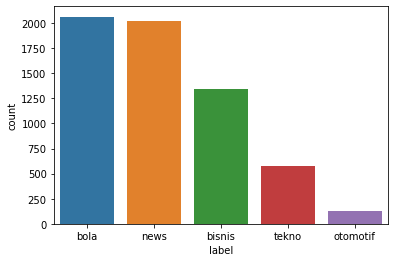

In [95]:
import seaborn as sns

sns.countplot(df['label'])

In [96]:
pip install Sastrawi

In [97]:
import re
import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


space = re.compile('[/(){}\[\]\|@,;]')
symbols = re.compile('[^0-9a-z #+_]')

stop_factory = StopWordRemoverFactory()
more_stopword = ['dengan', 'ia','bahwa','oleh']
data = set(stop_factory.get_stop_words()+more_stopword)
stopword = stop_factory.create_stop_word_remover()

def clean_text(text):
  text = text.lower()
  text = space.sub(' ', text)
  text = symbols.sub(' ', text)
  text = text.replace('x', '')
  text = ' '.join(word for word in text.split() if word not in data)
  return text

In [98]:
df['content']=df['content'].apply(clean_text)

In [99]:
print(df['content'][0])

liputan6 com london lee dion khawatir arsenal tak merekrut denis suarez permanen musim panas pasalnya sejauh suarez menjadi cadangan the gunners suarez dipinjam arsenal barcelona januari lalu the gunners membelinya akhir musim permainannya memuaskan sejauh suarez tak menjadi pilihan utama arsenal manajer unai emery baru memberinya kesempatan bermain selama 85 menit emery mungkin tahu kualitas suarez tahu suarez pemain dibutuhkannya kata dion dilansir evening standard sudut pandang suarez berpikir apa pindah kalau bermain jadi mungkin menolak arsenal katanya menambahkan


In [100]:
kategori = pd.get_dummies(df.label)
df = pd.concat([df, kategori], axis=1)
df = df.drop(columns=['label'])
print(df.head())
print(df.shape)

                                             content  bisnis  ...  otomotif  tekno
0  liputan6 com london lee dion khawatir arsenal ...       0  ...         0      0
1  liputan6 com jakarta kasus dugaan penganiayaan...       0  ...         0      0
2  liputan6 com jakarta menanggapi aksi eks peker...       1  ...         0      0
3  liputan6 com medan sebanyak 81 kendaraan 44 74...       0  ...         0      0
4  liputan6 com jakarta indonesia melawan thailan...       0  ...         0      0

[5 rows x 6 columns]
(6127, 6)


In [101]:
g=[]
for i in df['content']:
  g.append(i)
panjangmaks = max([len(s) for s in g])
print(panjangmaks) # max length dari padding

7206


In [102]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['content'].values)
word_index = tokenizer.word_index
print('token unik %s' % len(word_index))
print(df.columns)

token unik 37704
Index(['content', 'bisnis', 'bola', 'news', 'otomotif', 'tekno'], dtype='object')


In [103]:
from keras.preprocessing.sequence import pad_sequences

x= tokenizer.texts_to_sequences(df['content'].values)
x = pad_sequences(x, maxlen = 1000)
y = df[['bisnis', 'bola', 'news', 'otomotif', 'tekno']].values
print(x.shape)
print(y.shape)

(6127, 1000)
(6127, 5)


In [104]:
df.head()

,content,bisnis,bola,news,otomotif,tekno
0,liputan6 com london lee dion khawatir arsenal ...,0,1,0,0,0
1,liputan6 com jakarta kasus dugaan penganiayaan...,0,0,1,0,0
2,liputan6 com jakarta menanggapi aksi eks peker...,1,0,0,0,0
3,liputan6 com medan sebanyak 81 kendaraan 44 74...,0,1,0,0,0
4,liputan6 com jakarta indonesia melawan thailan...,0,1,0,0,0


In [105]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4901, 1000) (4901, 5)
(1226, 1000) (1226, 5)


In [106]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(50000, output_dim=16, input_length=1000),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1000, 16)          800000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 1000, 16)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               46800     
_________________________________________________________________
dense_34 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 325       
Total params: 868,309
Trainable params: 868,309
Non-trainable params: 0
_______________________________________________

In [107]:
from keras.callbacks import EarlyStopping

history = model.fit(x_train, y_train, epochs=10, callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=0)], batch_size=64, validation_split=0.2, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
62/62 [==============================] - 138s 2s/step - loss: 1.4073 - accuracy: 0.3464 - val_loss: 1.2647 - val_accuracy: 0.3293
Epoch 2/10
62/62 [==============================] - 138s 2s/step - loss: 0.8058 - accuracy: 0.6791 - val_loss: 0.4622 - val_accuracy: 0.8400
Epoch 3/10
62/62 [==============================] - 139s 2s/step - loss: 0.3302 - accuracy: 0.8939 - val_loss: 0.4135 - val_accuracy: 0.8614
Epoch 4/10
62/62 [==============================] - 137s 2s/step - loss: 0.1908 - accuracy: 0.9367 - val_loss: 0.4185 - val_accuracy: 0.8644
Epoch 5/10
62/62 [==============================] - 138s 2s/step - loss: 0.1236 - accuracy: 0.9577 - val_loss: 0.4226 - val_accuracy: 0.8685
Epoch 6/10
62/62 [==============================] - 137s 2s/step - loss: 0.1128 - accuracy: 0.9584 - val_loss: 0.4929 - val_accuracy: 0.8420


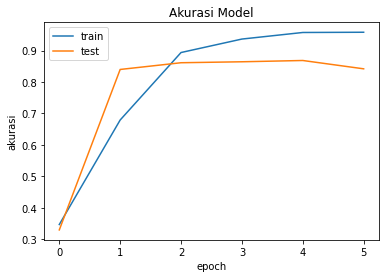

In [108]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('akurasi')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

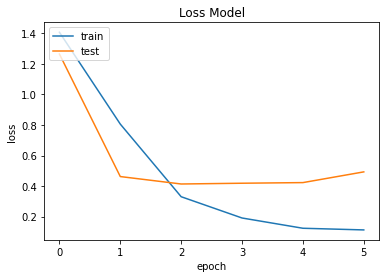

In [109]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()